In [1]:
# import dependencies
import torch
from datasets import load_dataset
import datasets
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
import random

###
from torch.autograd import Variable
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
import numpy as np
from SMILESDataset import SMILESDataset
from MoLFormerWithRegressionHead import MoLFormerWithRegressionHead

In [2]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

In [3]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

In [4]:
influence_scores = pd.read_table("influence_scores.txt", header=None)
influence_scores

,0
0,-6.021719
1,6.152141
2,-5.725117
3,6.385265
4,5.413464
...,...
295,-6.070569
296,6.113819
297,-4.806663
298,3.981204


array([[<Axes: title={'center': '0'}>]], dtype=object)

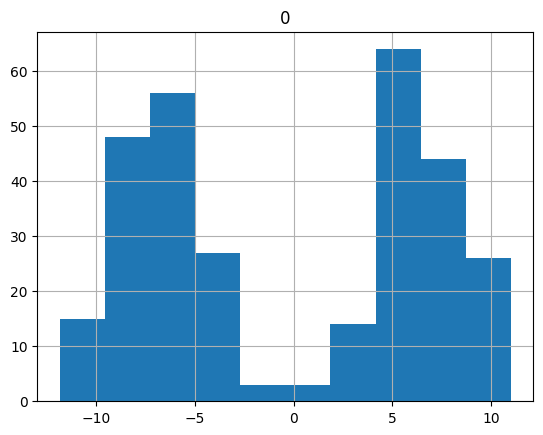

In [5]:
# histogram of influence scores
influence_scores.hist()

In [6]:
external_dataset = pd.read_csv("External-Dataset_for_Task2.csv")
external_dataset

,SMILES,Label
0,CCCCN1Cc2c(nc3cc(-c4ccco4)nn3c2O)C1=O,1.548
1,Cc1cc(C)c2c(n1)sc1c2ncnc1N1CCN(C)CC1,2.568
2,COC(=O)[C@H]1[C@H]2CC[C@H](C[C@@H]1OC(=O)c1ccc...,0.102
3,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Cl)c1,2.450
4,Cc1c[nH]c(/C=C2/C(=O)Nc3ccccc32)c1CCC(=O)O,1.040
...,...,...
295,O=C(N[C@@H]1CCCCCN(C(=O)c2ccccc2)C1)C1CCOCC1,1.554
296,CO[C@@H](C)CCC(=O)N[C@@H]1CCN(C(=O)c2ccccc2)C1,1.898
297,C[C@H](NC(=O)N1CCOC[C@@H]1C)c1cccc(N2CCCC2)c1,0.806
298,CCN(C(=O)Cc1ccc(C)cc1)[C@H]1CCN(CCO)C1,2.822


In [ ]:
n = 6.5

In [ ]:
dataset = load_dataset(DATASET_PATH)
train_dataset, test_dataset = train_test_split(SMILESDataset(dataset['train']['SMILES'], dataset['train']['label']), random_state=42) # same random state as the trained model
dataset = {'train': train_dataset, 'test': test_dataset} # original dataset

# augment the dataset with external data
external_dataset = external_dataset.iloc[influence_scores[abs(influence_scores[0]) > n].index].reset_index() # change n
external_dataset = SMILESDataset(external_dataset['SMILES'], external_dataset['Label']) # external dataset
dataset['train'] = torch.utils.data.ConcatDataset([dataset['train'], external_dataset]) # augmented dataset
train_dataset, val_dataset = train_test_split(dataset['train'], test_size=0.1,random_state=42) 

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True) # validation dataloader
train_dataloader = torch.utils.data.DataLoader(dataset['train'], batch_size=16,shuffle=True) # training dataloader
test_dataloader = torch.utils.data.DataLoader(dataset['test'], batch_size=16, shuffle=True) # test dataloader

In [ ]:
len(influence_scores[abs(influence_scores[0]) > n])/len(influence_scores) # number of positive influence scores

0.3233333333333333

In [9]:
print(len(dataset['train']))

3382


In [10]:
model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model = MoLFormerWithRegressionHead(model, 768).to(device)

In [12]:
import torch.optim as optim

# Loss function (Mean Squared Error)
criterion = torch.nn.MSELoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  
epochs = 20

In [ ]:
# this function is the same as Task 1


import matplotlib.pyplot as plt
import numpy as np

def train_with_early_stopping(train_dataloader, val_dataloader, test_dataloader, epochs, optimizer, criterion, model, tokenizer, device, patience=5):
    model.train()  # Set model to training mode
    
    train_losses = []
    val_losses = []
    test_losses = []
    
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(int(epochs)):
        total_train_loss = 0
        for batch in train_dataloader:
            smiles = batch['smiles']
            smiles = tokenizer(smiles, padding=True, return_tensors='pt').to(device)
            label = batch['label'].float().reshape(len(batch['label']), 1).to(device)

            optimizer.zero_grad()
            outputs = model(smiles['input_ids'], smiles['attention_mask'])

            loss = criterion(outputs, label)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                smiles = batch['smiles']
                smiles = tokenizer(smiles, padding=True, return_tensors='pt').to(device)
                label = batch['label'].float().reshape(len(batch['label']), 1).to(device)

                outputs = model(smiles['input_ids'], smiles['attention_mask'])
                loss = criterion(outputs, label)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break
        
        model.train()

    # Test phase
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            smiles = batch['smiles']
            smiles = tokenizer(smiles, padding=True, return_tensors='pt').to(device)
            label = batch['label'].reshape(len(batch['label']), 1).to(device)
    
            outputs = model(smiles['input_ids'], smiles['attention_mask'])
            
            # Ensure output shape matches target shape
            loss = criterion(outputs, label)
            total_test_loss += loss.item()
    
    avg_test_loss = total_test_loss / len(test_dataloader)
    print(f"Final Test Loss: {avg_test_loss:.4f}")  # Explicitly print test loss
    
    # Plot losses
    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='blue')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color='red')
    plt.axhline(y=avg_test_loss, color='black', linestyle='--', label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Epoch vs Loss")
    plt.show()


Epoch [1/20], Train Loss: 0.9329, Val Loss: 0.5970
Epoch [2/20], Train Loss: 0.5291, Val Loss: 0.3349
Epoch [3/20], Train Loss: 0.3795, Val Loss: 0.2079
Epoch [4/20], Train Loss: 0.2954, Val Loss: 0.1725
Epoch [5/20], Train Loss: 0.2673, Val Loss: 0.1955
Epoch [6/20], Train Loss: 0.2074, Val Loss: 0.1420
Epoch [7/20], Train Loss: 0.1744, Val Loss: 0.1417
Epoch [8/20], Train Loss: 0.1526, Val Loss: 0.1091
Epoch [9/20], Train Loss: 0.1482, Val Loss: 0.1066
Epoch [10/20], Train Loss: 0.1316, Val Loss: 0.1375
Epoch [11/20], Train Loss: 0.1245, Val Loss: 0.0966
Epoch [12/20], Train Loss: 0.1194, Val Loss: 0.0955
Epoch [13/20], Train Loss: 0.1133, Val Loss: 0.0796
Epoch [14/20], Train Loss: 0.1065, Val Loss: 0.0809
Epoch [15/20], Train Loss: 0.1075, Val Loss: 0.1645
Epoch [16/20], Train Loss: 0.0965, Val Loss: 0.0905
Early stopping triggered!
Final Test Loss: 0.4119


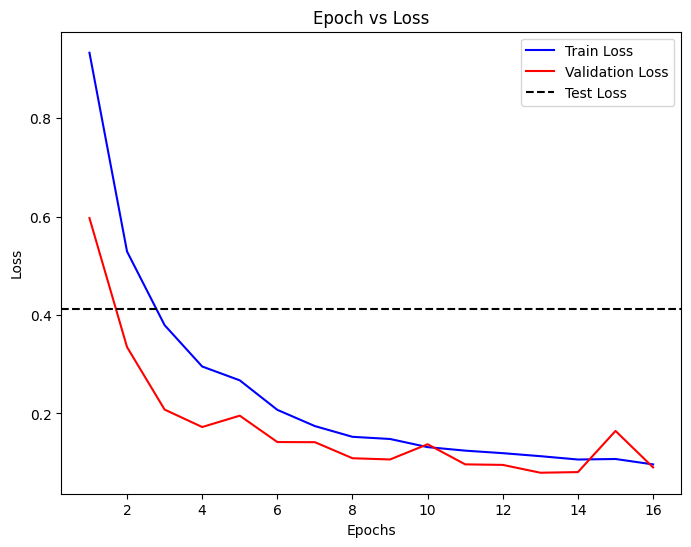

In [16]:
train_with_early_stopping(train_dataloader, val_dataloader, test_dataloader, epochs, optimizer, criterion, regression_model, tokenizer, device, patience=3)

In [ ]:
# MSE 77 % 0.4199
# MSE 50 % 0.4353
# MSE 33 % 0.4599